In [2]:
import numpy as np
import matplotlib.pyplot as plt

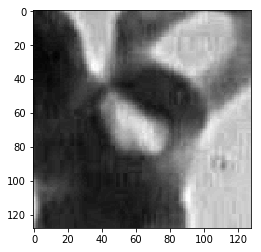

In [3]:
from PIL import Image, ImageDraw
import requests

url = 'https://www.worldgbc.org/sites/default/files/Content%20pages%20old%20europe%20buildings.jpg'
path = "./BloodImage_00004.jpg"

# img = Image.open(requests.get(url, stream=True).raw).convert('L')
img = Image.open(path).convert('L')
# img = np.array(img).astype(np.float64)[:, 400:950] / 255
img = np.array(img).astype(np.float64)[:128, :128]

plt.imshow(img, cmap='gray')

In [5]:
X_orig = img.copy()

np.linalg.norm(X_orig, ord="nuc")

26415.172146718258

In [6]:
def f(x, b):
    return np.sum((x - b) ** 2)

def grad_f(x):
    b = X_orig.copy().reshape(-1)
    return 2 * (x - b) 

In [7]:
def f(x, b):
    return np.mean(x - b * np.log(x))

def grad_f(x):
    b = X_orig.copy().reshape(-1)
    return 1 - b / x

In [8]:
def A(X):
    return X.reshape(-1)

def A_star(x):
    return x.reshape(X_orig.shape)

In [9]:
X_0 = X_orig.copy()

In [10]:
err = []

In [11]:
from scipy.sparse import linalg as slin
from tqdm import tqdm

class Sketch:
    def __init__(self):
        self.Omega = None
        self.Psi = None
        self.Y = None
        self.W = None
        self.shape = None
        self.r = 0
    
    def init(self, X_orig, r):
        self.r = r
        
        m, n = X_orig.shape
        self.shape = X_orig.shape
        
        k = 2 * r + 1
        l = 4 * r + 3
        
        self.Omega = np.random.randn(n, k)
        self.Psi = np.random.randn(l, m)
        
        self.Y = np.zeros((m, k))
        self.W = np.zeros((l, n))

#         self.Y = X_orig @ self.Omega
#         self.W = self.Psi @ X_orig
        
    def CGMU_update(self, u, v, nu):
        self.Y = (1 - nu) * self.Y + nu * u @ (v.T @ self.Omega)
        self.W = (1 - nu) * self.W + nu * (self.Psi @ u) @ v.T
        
    def reconstruct(self):
        Q, _ = np.linalg.qr(self.Y)
        B = np.linalg.pinv(self.Psi @ Q) @ self.W
        
        U, S, V = np.linalg.svd(B, full_matrices=False)
                
        return Q @ U[:,:self.r] @ np.diag(S[:self.r]) @ V[:self.r,:]
    
    def factorize(self, num_iter=500, alpha = 1.0, eps=1e-10):
        z = np.ones(self.shape).reshape(-1)
        
        for i in tqdm(range(num_iter)):
            u, _, v = np.linalg.svd(A_star(grad_f(z)))
            u = u[:,:1]
            v = v[:1,:].T
            
            h = A((-alpha * u @ v.T))
            e = (z - h) @ grad_f(z)
            
            err.append(np.abs(e))
            if np.abs(e) <= eps :
                break
            
            nu = 2 / (i + 2)
            z = (1 - nu) * z + nu * h
            self.CGMU_update(-alpha * u, v, nu)

In [12]:
err = []
sketch = Sketch()
sketch.init(X_0, 400)
# sketch.factorize(alpha=np.trace(X_0))
sketch.factorize(alpha=26415)
X_rec = sketch.reconstruct()

100%|██████████| 500/500 [00:02<00:00, 241.07it/s]


6


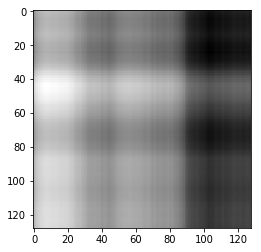

In [13]:
# X_rec = U @ np.diag(S) @ V

print(np.linalg.matrix_rank(X_rec))

plt.imshow(X_rec, cmap='gray')

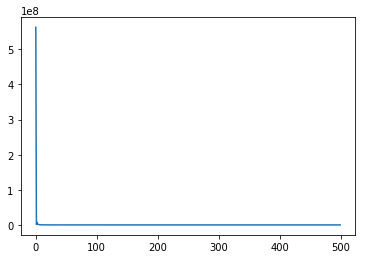

In [14]:
plt.plot(err)

In [15]:
import cvxpy as cvx

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 98688, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 65664, constraints m = 98433
Cones:	primal zero / dual free vars: 16384
	linear vars: 1
	sd vars: 32896, sd blks: 1
	exp vars: 49152, dual exp vars: 0
Setup time: 2.06e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.24e+01  1.52e+01  9.92e-01 -6.63e+12 -2.51e+10  1.81e-03  3.04e-01 
   100| 2.70e-04  1.29e-03  4.09e-04 -2.38e+11 -2.38e+11  4.10e-06  1

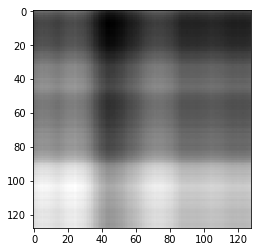

In [16]:
X = cvx.Variable(img.shape)

b = A(X_orig)
def conv_f(X):
    return cvx.sum(cvx.vec(X) - b * cvx.log(cvx.vec(X)))

objective = cvx.Minimize(conv_f(X))

alpha = 26415

constraints = [
    cvx.norm(X, "nuc") <= alpha
]

p = cvx.Problem(objective, constraints)
p.solve(verbose=True)

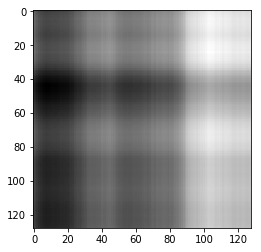

In [17]:
plt.imshow(X.value.T, cmap='gray')